In [52]:
import pandas as pd
import mysql.connector
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Conectarse a la base de datos: 
cnx = mysql.connector.connect(user='root', password='azkenmugaÑ.', port="6006",
                              host='golem.us.es', database='wqp')

# Crear un cursor
cursor = cnx.cursor()

# Definir la consulta SQL con el filtro de fecha
# query = "SELECT * FROM ASV_US.ASV WHERE date(Date) >= '2024-02-16' AND date(Date) <= '2024-02-15'"
date = '2024-02-27'
query = f"SELECT * FROM wqp.WQP where date(Date) = '{date}';"

# Ejecutar la consulta
cursor.execute(query)

# Obtener nombres de columnas
column_names = cursor.column_names

# Obtener los resultados
results = cursor.fetchall()

# Cerrar el cursor y la conexión a la base de datos
cursor.close()
cnx.close()

# Crear un DataFrame de pandas con los resultados
df = pd.DataFrame(results, columns=column_names)

# Mostrar el DataFrame
print(df)

                     Date    Latitude   Longitude          Sensor  ASV  \
0     2024-02-27 10:29:44        0E-7        0E-7       Turbidity    1   
1     2024-02-27 10:29:44        0E-7        0E-7           Sonar    1   
2     2024-02-27 10:29:44        0E-7        0E-7         Battery    1   
3     2024-02-27 10:29:44        0E-7        0E-7              PH    1   
4     2024-02-27 10:29:44        0E-7        0E-7     Temperature    1   
...                   ...         ...         ...             ...  ...   
57414 2024-02-27 13:44:29  37.4185484  -6.0011738     Temperature    1   
57415 2024-02-27 13:44:29  37.4185484  -6.0011738              PH    1   
57416 2024-02-27 13:44:29  37.4185484  -6.0011738  Sensor_battery    1   
57417 2024-02-27 13:44:29  37.4185484  -6.0011738    Conductivity    1   
57418 2024-02-27 13:44:29  37.4185485  -6.0011739           Sonar    1   

             Data  
0        23.75960  
1      2210.00000  
2        81.87500  
3         7.80059  
4        14

In [2]:
# import plotly.express as px

# # Pintar datos en bruto
# fig = px.scatter_geo(df,lat='Latitude',lon='Longitude', hover_name="Sensor")
# fig.update_layout(title = 'World map', title_x=0.5)
# fig.show()

In [3]:
# Load the image
selected_map = 'alamillo'
image = cv2.imread(f'Maps/{selected_map.capitalize()}Image2.png', 0)

# Binarize the image
_, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

# Convert the binary image to 0s and 1s
binary_image = np.where(binary_image > 0, 1, 0)

# Save the binary image as a CSV file
np.savetxt(f'Maps/{selected_map}.csv', binary_image, delimiter=',', fmt='%d')


In [4]:
# import pyproj

# LAT_LON_GOOGLE = (37.418504073694265, -6.000393177903226)
# LAT_LON_GPS =  (37.41834, -6.00158)

# # Convertir a latlon a xy epsg:3857

# # Definir el sistema de coordenadas de entrada
# inProj = pyproj.Proj(init='epsg:4326')

# # Convertir de xy a latlon epsg:3857

# # Definir el sistema de coordenadas de salida
# outProj = pyproj.Proj(init='epsg:3857')

# # Convertir las coordenadas

# print("GOOGLE: ",pyproj.transform(inProj, outProj, LAT_LON_GOOGLE[1], LAT_LON_GOOGLE[0]))
# print("GPS: ", pyproj.transform(inProj, outProj, LAT_LON_GPS[1], LAT_LON_GPS[0]))




In [53]:
import utm
if selected_map == 'alamillo':
    # map_coords = { 'lat_min': 37.418434546104805, 'lat_max': 37.42068457115037, 'lon_min': -6.001406352925818, 'lon_max': -5.997440785761399 }
    # map_coords = { 'lat_min': 37.41834, 'lat_max': 37.42075, 'lon_min': -6.00158, 'lon_max': -5.9973 }
    map_coords = { 'lat_min': 37.417823087, 'lat_max': 37.421340387, 'lon_min': -6.001553482, 'lon_max': -5.997342323 }
    pos_ini = utm.from_latlon(map_coords['lat_min'], map_coords['lon_min'])
    scenario_map = np.genfromtxt(f'Maps/{selected_map}.csv', delimiter=',') 
    # cargar imagen satelite
    satelite_img = plt.imread(f'Maps/{selected_map.capitalize()}Sat.png')

In [6]:
# WQPs de mediciones
sensores = [*df['Sensor'].unique()]

if 'Sensor_battery' in sensores:
    sensores.remove('Sensor_battery')
if 'Battery' in sensores:
    sensores.remove('Battery')

# Eliminar las muestras con coordenadas GPS no válidas
df_procesado = df[df['Latitude'] != 0].reset_index(drop=True)
df_procesado = df[df['Longitude'] != 0].reset_index(drop=True)

# Encontrar indice del primer dato dentro del agua basándonos en conductividad distinta de cero + margen de estabilización
df_cond = df_procesado[df_procesado['Sensor'] == 'Conductivity'].reset_index(drop=True)
ini_index = df_cond[df_cond['Data'] != 0].index[0] + 10




from math import radians, cos, sin, sqrt, atan2

def haversine(lat1, lon1, lat2, lon2):
    # Radio de la Tierra en kilómetros
    R = 6371.0
    
    # Convertir coordenadas de grados a radianes
    lat1_rad = radians(lat1)
    lon1_rad = radians(lon1)
    lat2_rad = radians(lat2)
    lon2_rad = radians(lon2)
    
    # Diferencias de coordenadas
    dlon = lon2_rad - lon1_rad
    dlat = lat2_rad - lat1_rad
    
    # Fórmula del haversine
    a = sin(dlat / 2)**2 + cos(lat1_rad) * cos(lat2_rad) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    
    # Distancia total en kilómetros
    distance = R * c * 1000
    return distance

# Obtener coordenadas UTM a partir a partir de la distancia en latitud y longitud, ya que hay cambio de zona UTM en el mapa de Alamillo
# df_procesado['X'] = utm.from_latlon(df_procesado['Latitude'].astype(float).to_numpy(), df_procesado['Longitude'].astype(float).to_numpy())[0] - pos_ini[0]
# df_procesado['Y'] = utm.from_latlon(df_procesado['Latitude'].astype(float).to_numpy(), df_procesado['Longitude'].astype(float).to_numpy())[1] - pos_ini[1]

# Convertir las coordenadas GPS a metros respecto al inicio de la imagen con la función haversine
df_procesado['Y'] = df_procesado.apply(lambda row: haversine(map_coords['lat_min'], map_coords['lon_min'], row['Latitude'], map_coords['lon_min']), axis=1)
df_procesado['X'] = df_procesado.apply(lambda row: haversine(map_coords['lat_min'], map_coords['lon_min'], map_coords['lat_min'], row['Longitude']), axis=1)

# Guardar el DataFrame en un archivo CSV con la fecha
df_procesado.to_csv(f'wqp_{date}.csv', index=False)

print(df_procesado)

                     Date    Latitude   Longitude          Sensor  ASV  \
0     2024-02-27 10:45:56  37.4185472  -6.0011976       Turbidity    1   
1     2024-02-27 10:45:56  37.4185472  -6.0011976              PH    1   
2     2024-02-27 10:45:56  37.4185472  -6.0011976         Battery    1   
3     2024-02-27 10:45:56  37.4185472  -6.0011976     Temperature    1   
4     2024-02-27 10:45:56  37.4185472  -6.0011976    Conductivity    1   
...                   ...         ...         ...             ...  ...   
53652 2024-02-27 13:44:29  37.4185484  -6.0011738     Temperature    1   
53653 2024-02-27 13:44:29  37.4185484  -6.0011738              PH    1   
53654 2024-02-27 13:44:29  37.4185484  -6.0011738  Sensor_battery    1   
53655 2024-02-27 13:44:29  37.4185484  -6.0011738    Conductivity    1   
53656 2024-02-27 13:44:29  37.4185485  -6.0011739           Sonar    1   

            Data          Y          X  
0       20.19600  80.517692  31.429314  
1        7.77070  80.517692  

In [7]:
# sensor_df = df_procesado[df_procesado['Sensor'] == 'Conductivity'].reset_index(drop=True)
# muestras_finales_a_quitar = 10
# sensor_df = sensor_df.iloc[ini_index:-muestras_finales_a_quitar, :].reset_index(drop=True)
# print(sensor_df.head(-10))

C:\Users\amend\AppData\Local\Temp\ipykernel_26608\4185149223.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sensor_df[condition]


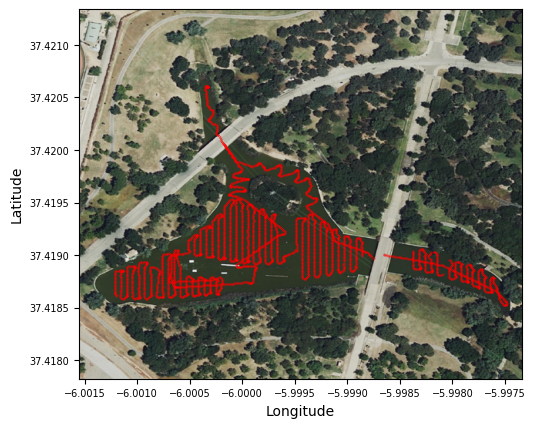

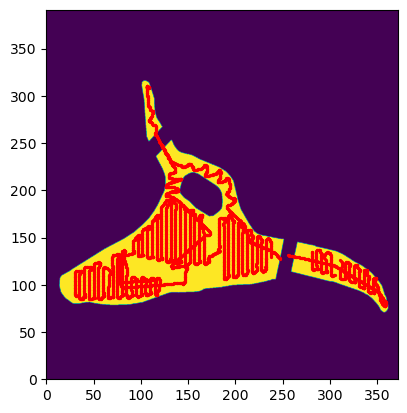

In [77]:
# Pintar en el mapa la posición de todas las muestras
import matplotlib.pyplot as plt


sensor = 'Conductivity' # ['Conductivity', 'PH', 'Sonar', 'Temperature', 'Turbidity']


sensor_df = df_procesado[df_procesado['Sensor'] == sensor].reset_index(drop=True)

# Seleccionar rango de la misión
condition = (sensor_df['Date'] > '2024-02-27 11:46:16') & (sensor_df['Date'] < '2024-02-27 13:18:16')
sensor_df = sensor_df[condition].reset_index(drop=True)
# Eliminar muestras en un rango de tiempo
rango_perdida_gps = (sensor_df['Date'] > f'2024-02-27 12:42:16') & (sensor_df['Date'] < f'2024-02-27 12:43:16')
rango_paso_puente= (sensor_df['Date'] > f'2024-02-27 12:37:16') & (sensor_df['Date'] < f'2024-02-27 12:39:16')
rango_paso_puente_vuelta= (sensor_df['Date'] > f'2024-02-27 12:51:26') & (sensor_df['Date'] < f'2024-02-27 12:51:38')
rango_ramas = (sensor_df['Date'] > f'2024-02-27 13:00:00') & (sensor_df['Date'] < f'2024-02-27 13:10:00')
suma_rangos = rango_perdida_gps | rango_paso_puente | rango_paso_puente_vuelta | rango_ramas
sensor_df = sensor_df[~suma_rangos]
# sensor_df = sensor_df[rango_tiempo].reset_index(drop=True)

sensor_df[condition]

# Convertir las coordenadas GPS a metros respecto al inicio de la imagen
# img = plt.imread('AlamilloImage.png')
p0 = utm.from_latlon(map_coords['lat_min'], map_coords['lon_min'])
# p1 = utm.from_latlon(map_coords['lat_max'], map_coords['lon_max'], force_zone_number=p0[2])
p1_x = haversine(map_coords['lat_min'], map_coords['lon_min'], map_coords['lat_min'], map_coords['lon_max'])
p1_y = haversine(map_coords['lat_min'], map_coords['lon_min'], map_coords['lat_max'], map_coords['lon_min'])
p1 = (p0[0] + p1_x, p0[1] + p1_y)

x0_extend = p0[0] - pos_ini[0]
y0_extend = p0[1] - pos_ini[1]
x1_extend = p1[0] - pos_ini[0]
y1_extend = p1[1] - pos_ini[1]


# Pintar el mapa de latitud y longitud
plt.imshow(satelite_img, extent=[map_coords['lon_min'], map_coords['lon_max'], map_coords['lat_min'], map_coords['lat_max']]) # extend=[xmin,xmax,ymin,ymax]
plt.scatter(sensor_df['Longitude'].to_numpy(), sensor_df['Latitude'].to_numpy(), c='r', s=0.3, marker='.')
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
# plt.savefig('ruta.svg')
plt.show()

# Pintra el mapa de UTM
plt.imshow(scenario_map, extent=[x0_extend, x1_extend, y0_extend, y1_extend])
plt.scatter(sensor_df['X'].to_numpy(), sensor_df['Y'].to_numpy(), c='r', s=7, marker='.')
plt.show()

In [9]:
# Dimensiones mapa
rows, cols = scenario_map.shape

# Resolución de la matriz
res_lat, res_lon = (map_coords['lat_max'] - map_coords['lat_min']) / rows, (map_coords['lon_max'] - map_coords['lon_min']) / cols

def gps_to_matrix_idx(lat, lon, lat_max, lon_min, res_lat, res_lon):
    row_idx = int((lat_max - lat) / res_lat)
    col_idx = int((lon - lon_min) / res_lon)

    # Limitar los índices dentro de los rangos válidos de la matriz
    # row_idx = max(0, min(row_idx, rows - 1))
    # col_idx = max(0, min(col_idx, cols - 1))

    return row_idx, col_idx

# Ejemplo de uso para una muestra con coordenadas GPS
lat_sample, lon_sample = df['Latitude'].astype(float).iloc[100], df['Longitude'].astype(float).iloc[100]
row_idx, col_idx = gps_to_matrix_idx(lat_sample, lon_sample, map_coords['lat_max'], map_coords['lon_min'], res_lat, res_lon)

print(f"Image shape: ({rows}, {cols})")
print(f"Resolution: ({res_lat}, {res_lon})")
print(f"Coordinates in the map: ({row_idx}, {col_idx})")

Image shape: (1334, 1598)
Resolution: (2.6366566716631283e-06, 2.63526846057601e-06)
Coordinates in the map: (14192723, 2277397)


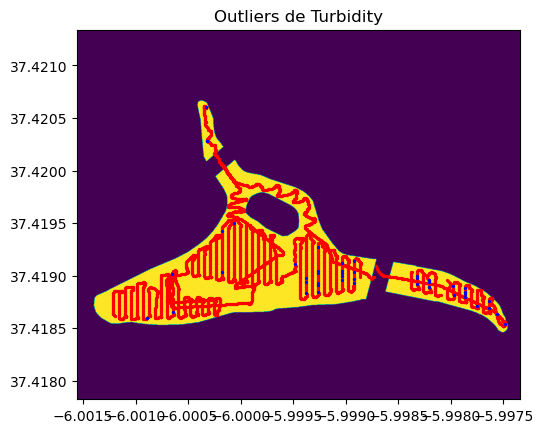

C:\Users\amend\AppData\Local\Temp\ipykernel_26608\880217583.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sensor_df = sensor_df[~suma_rangos].reset_index(drop=True)


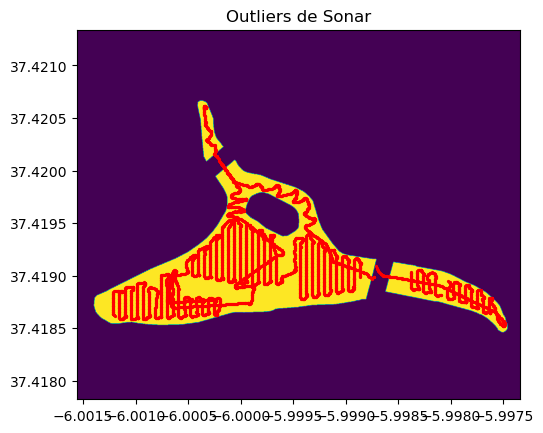

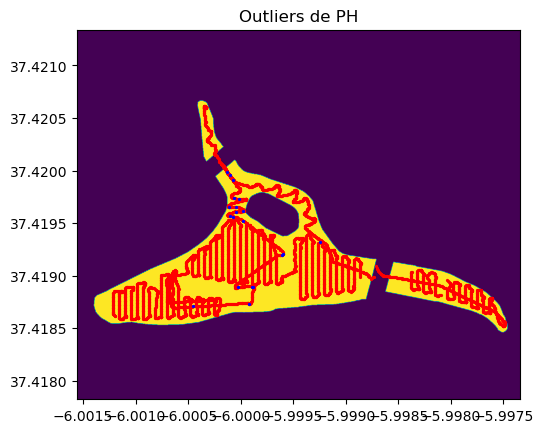

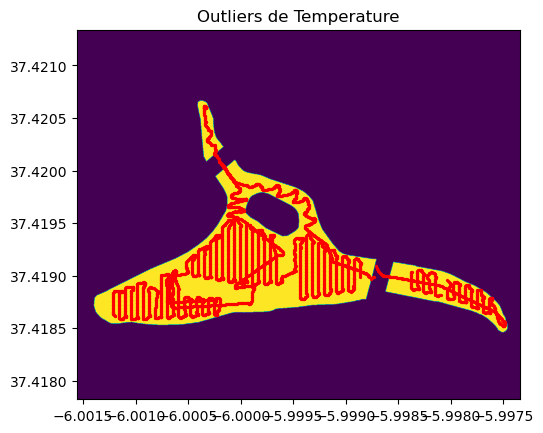

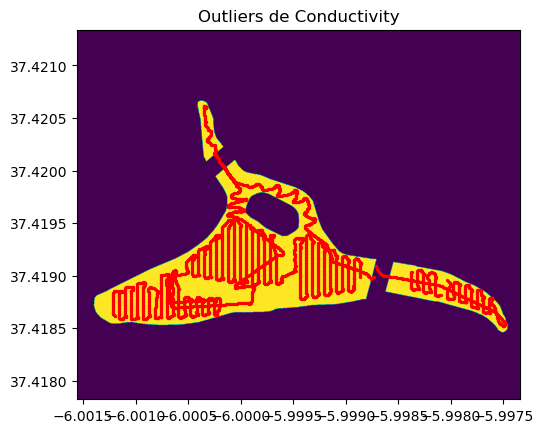

In [22]:
sensor = 'PH'
for sensor in sensores:
    sensor_df = df_procesado[df_procesado['Sensor'] == sensor].reset_index(drop=True)
    sensor_df = sensor_df[(sensor_df['Date'] > '2024-02-27 11:46:16') & (sensor_df['Date'] < '2024-02-27 13:18:16')].reset_index(drop=True)
    sensor_df = sensor_df[~suma_rangos].reset_index(drop=True)

    # Ver el valor minimo de Data diferente de cero
    # print(sensor_df[sensor_df['Data'] != 0].min())
    # print(sensor_df['Data'].min())
    # print(sensor_df['Data'].max())

    # Obtener la fecha donde esta ese valor minimo
    # print(sensor_df[sensor_df['Data'] == sensor_df['Data'].min()])

    import seaborn as sns
    # Representar outliers
    Q1 = sensor_df['Data'].quantile(0.25)
    Q3 = sensor_df['Data'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = sensor_df[(sensor_df['Data'] < (Q1 - 4 * IQR)) | (sensor_df['Data'] > (Q3 + 4 * IQR))]
    # print(outliers)
    # Representar en el mapa los outliers
    plt.imshow(scenario_map, extent=(map_coords['lon_min'], map_coords['lon_max'], map_coords['lat_min'], map_coords['lat_max']))# extend=[xmin,xmax,ymin,ymax]
    plt.scatter(sensor_df['Longitude'].to_numpy(), sensor_df['Latitude'].to_numpy(), c='r', s=7, marker='.')
    plt.scatter(outliers['Longitude'].to_numpy(), outliers['Latitude'].to_numpy(), c='b', s=7, marker='.')
    plt.title(f'Outliers de {sensor}')
    plt.show()

    # Representar todas las mediciones de datos
    # plt.figure(figsize=(10, 6))
    # sns.histplot(sensor_df['Data'], kde=True, bins=50)

    # Representar las mediciones en el mapa
    # plt.imshow(scenario_map, extent=(map_coords['lon_min'], map_coords['lon_max'], map_coords['lat_min'], map_coords['lat_max']))# extend=[xmin,xmax,ymin,ymax]
    # plt.scatter(sensor_df['Longitude'].to_numpy(), sensor_df['Latitude'].to_numpy(), c=sensor_df['Data'].to_numpy(), s=7, marker='.')
    # plt.colorbar(label=sensor)
    # plt.title(f'Mediciones de {sensor}')

Text(0.5, 1.0, 'Mediciones de Temperature')

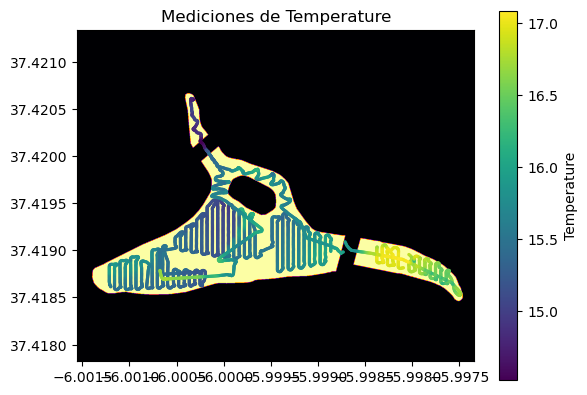

In [36]:
sensor = 'Temperature'
sensor_df = df_procesado[df_procesado['Sensor'] == sensor].reset_index(drop=True)
sensor_df = sensor_df[(sensor_df['Date'] > '2024-02-27 11:46:16') & (sensor_df['Date'] < '2024-02-27 13:18:16')].reset_index(drop=True)
sensor_df = sensor_df[~suma_rangos].reset_index(drop=True)
plt.imshow(scenario_map, extent=(map_coords['lon_min'], map_coords['lon_max'], map_coords['lat_min'], map_coords['lat_max']), cmap='inferno')
plt.scatter(sensor_df['Longitude'].to_numpy(), sensor_df['Latitude'].to_numpy(), c=sensor_df['Data'].to_numpy(), s=7, marker='.')
plt.colorbar(label=sensor)
plt.title(f'Mediciones de {sensor}')

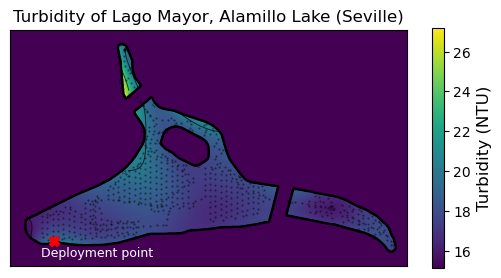

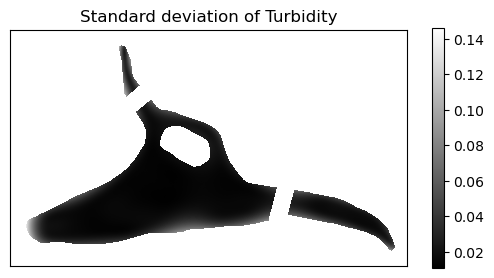

C:\Users\amend\AppData\Local\Temp\ipykernel_26608\1532001669.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sensor_df = sensor_df[~suma_rangos].reset_index(drop=True)


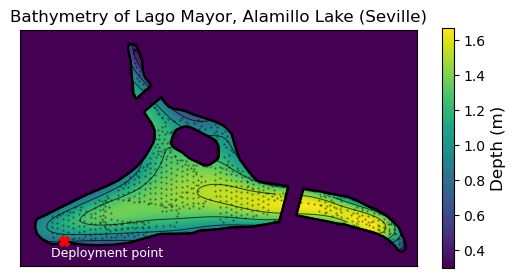

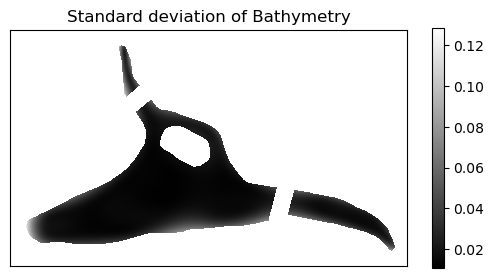

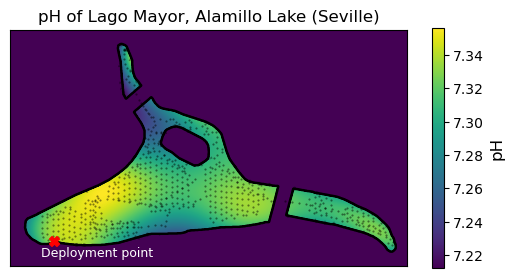

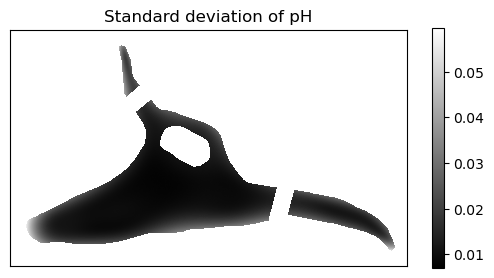

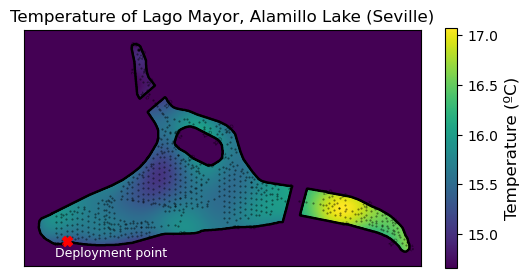

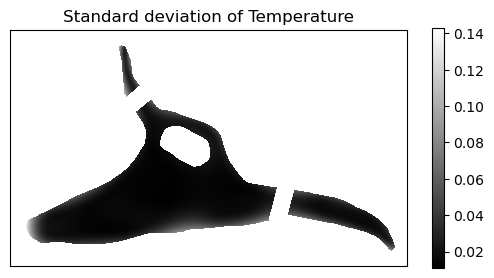

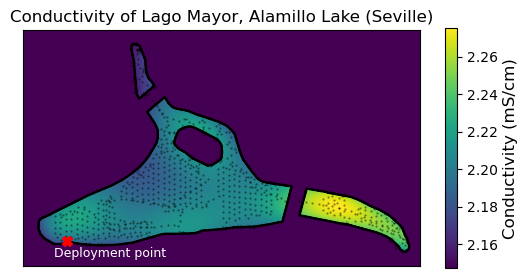

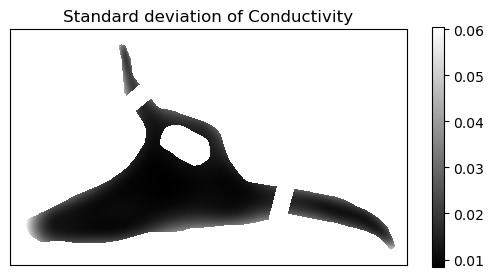

In [82]:
import torch
from GPModels import GaussianProcessGPyTorch 
import colorcet

def get_gp(sensor):
    sensor_df = df_procesado[df_procesado['Sensor'] == sensor].reset_index(drop=True)
    sensor_df = sensor_df[(sensor_df['Date'] > '2024-02-27 11:46:16') & (sensor_df['Date'] < '2024-02-27 13:18:16')].reset_index(drop=True)
    sensor_df = sensor_df[~suma_rangos].reset_index(drop=True)

    # Quitar las medidas con valor cero
    sensor_df = sensor_df[sensor_df['Data'] != 0].reset_index(drop=True)

    # Limpiar outliers
    # Q1 = sensor_df['Data'].quantile(0.25)
    # Q3 = sensor_df['Data'].quantile(0.75)
    # IQR = Q3 - Q1
    # sensor_df = sensor_df[~((sensor_df['Data'] < (Q1 - 3 * IQR)) | (sensor_df['Data'] > (Q3 + 3 * IQR)))]

    # Recortar a una de cada n muestras
    n = 8
    latitudes = np.array(sensor_df['Latitude'].astype(float))[::n]
    longitudes = np.array(sensor_df['Longitude'].astype(float))[::n]
    y, x = zip(*[gps_to_matrix_idx(lat, lon, map_coords['lat_max'], map_coords['lon_min'], res_lat, res_lon) for lat, lon in zip(latitudes, longitudes)])
    # y, x = np.array(sensor_df['Y'].astype(float))[::n], np.array(sensor_df['X'].astype(float))[::n]
    xy = list(zip(y, x)) # Pares de coordenadas GPS

    if sensor == 'Sonar':
        # Pasar a metros
        data = np.array(sensor_df['Data'].astype(float))[::n] / 1000
    else:
        data = np.array(sensor_df['Data'].astype(float))[::n]
        
    gaussian_process = GaussianProcessGPyTorch(scenario_map = scenario_map, initial_lengthscale = 300, kernel_bounds = (200, 400), training_iterations = 50, scale_kernel=True, device = 'cuda' if torch.cuda.is_available() else 'cpu')
    gaussian_process.fit_gp(X_new=xy, y_new=data, variances_new=[0.005]*len(data))
    mean_map, uncertainty_map = gaussian_process.predict_gt()
    return mean_map, uncertainty_map, x, y

def plot_mean(mean_map, sensor, x, y):
    fig, axis = plt.subplots()
    # Punto de despliegue
    plt.text(350, 1100, 'Punto de despliegue', fontsize=9, rotation=0, ha='center', va='center', color='w')
    plt.scatter(175, 1050, c='r', s=50, marker='X', zorder=2)
    plt.xticks([])
    plt.yticks([])

    # Contorno
    cs_internos = plt.contour(mean_map, colors='black', alpha=0.7, linewidths=0.7, zorder=1)
    cs_externo = plt.contour(mean_map, colors='black', alpha=1, linewidths=1.7, zorder=1)

    cs_internos.collections[0].remove()
    for i in range(1, len(cs_externo.collections)):
        cs_externo.collections[i].remove()
    plt.clabel(cs_internos, inline=1, fontsize=3.5)

    # Mapa y puntos de muestreo
    plt.scatter(x, y, c='black', s=1, marker='.', alpha=0.5)
    # vmin_dict = {'Sonar': 2, 'Conductivity': 2.29, 'PH': 7.48, 'Temperature': 17.1, 'Turbidity': 30}
    # vmax_dict = {'Sonar': 0.5, 'Conductivity': 2.14, 'PH': 7.16, 'Temperature': 14.50, 'Turbidity': 15}
    # plt.imshow(mean_map, cmap='viridis', alpha=1, origin='upper', vmin=vmin_dict[sensor], vmax=vmax_dict[sensor])
    vmin = np.min(mean_map[mean_map > 0])
    vmax = np.max(mean_map[mean_map > 0])
    plt.imshow(mean_map, cmap='viridis', alpha=1, origin='upper', vmin=vmin, vmax=vmax)

    # Recortar el mapa
    if selected_map == 'alamillo':
        plt.ylim(1150, 200)

    # Leyendas
    unidades_dict = {'Sonar': 'Profundidad (m)', 'Conductivity': 'Conductividad (mS/cm)', 'PH': 'pH', 'Temperature': 'Temperatura (ºC)', 'Turbidity': 'Turbidez (NTU)'}
    nombre_dict = {'Sonar': 'Batimetría', 'Conductivity': 'Conductividad', 'PH': 'pH', 'Temperature': 'Temperatura', 'Turbidity': 'Turbidez'}
    plt.colorbar(shrink=0.65).set_label(label=unidades_dict[sensor],size=12)#,weight='bold')
    if selected_map == 'alamillo':
        # plt.text(1950, 650, unidades_dict[sensor], fontsize=12, rotation=90, ha='center', va='center', color='k')
        plt.title(f'{nombre_dict[sensor]} del Lago Mayor (Parque del Alamillo)')

    plt.savefig(f'./{nombre_dict[sensor]}_{selected_map}.pdf', format='pdf')
    plt.show()

def plot_uncertainty(uncertainty_map, sensor):
    non_water_mask = scenario_map == 0
    uncertainty_map[non_water_mask] = np.nan
    plt.imshow(uncertainty_map, cmap='gray', alpha=1, origin='upper')
    plt.xticks([])
    plt.yticks([])
    # Recortar el mapa
    if selected_map == 'alamillo':
        plt.ylim(1150, 200)
    plt.colorbar(shrink=0.65)
    nombre_dict = {'Sonar': 'Batimetría', 'Conductivity': 'Conductividad', 'PH': 'pH', 'Temperature': 'Temperatura', 'Turbidity': 'Turbidez'}
    if selected_map == 'alamillo':
        plt.title(f'Desviación típica de {nombre_dict[sensor]}')
    plt.savefig(f'./{nombre_dict[sensor]}_{selected_map}_std.pdf', format='pdf')
    plt.show()

# Obtener todos los mapas de predicción
for sensor in sensores: # ['Conductivity', 'PH', 'Sonar', 'Temperature', 'Turbidity']
    mean_map, uncertainty_map, x, y = get_gp(sensor)
    plot_mean(mean_map, sensor, x, y)
    plot_uncertainty(uncertainty_map, sensor)




In [43]:
# Unir pdfs en uno solo
from PyPDF2 import PdfMerger
import os

nombres = ['Batimetría', 'pH', 'Temperatura', 'Conductividad', 'Turbidez']
pdfs_medidas = [f'{nombre}_{selected_map}.pdf' for nombre in nombres]
pdfs_std = [f'{nombre}_{selected_map}_std.pdf' for nombre in nombres]


import fitz  # PyMuPDF

def combinar_paginas_pdf(pdf1_path, pdf2_path, salida_pdf_path):
    # Abrir los documentos PDF originales
    doc1 = fitz.open(pdf1_path)
    doc2 = fitz.open(pdf2_path)
    
    # Crear un nuevo documento PDF para la salida
    doc_salida = fitz.open()
    
    # Asegurarse de que cada documento tiene al menos una página
    if len(doc1) > 0 and len(doc2) > 0:
        # Crear una nueva página en el documento de salida con el doble del ancho de la primera página del primer documento
        rect1 = doc1[0].rect  # Obtiene las dimensiones de la primera página del primer PDF
        rect2 = fitz.Rect(rect1.width, 0, rect1.width * 2, rect1.height)  # Define el rectángulo para el segundo documento
        
        nueva_pagina = doc_salida.new_page(width=rect1.width * 2, height=rect1.height)
        
        # Dibujar la primera página de cada documento en la nueva página
        nueva_pagina.show_pdf_page(rect1, doc1, 0)  # Primera página de doc1 a la izquierda
        nueva_pagina.show_pdf_page(rect2, doc2, 0)  # Primera página de doc2 a la derecha
    
    # Guardar el documento de salida
    doc_salida.save(salida_pdf_path)
    doc_salida.close()
    doc1.close()
    doc2.close()

# Combinar las páginas de los PDFs
pdfs_combinados = []
for pdf_medida, pdf_std in zip(pdfs_medidas, pdfs_std):
    out = f'./{pdf_medida[:-4]}_combinado.pdf'
    combinar_paginas_pdf(pdf_medida, pdf_std, out)
    pdfs_combinados.append(out)

# Fusionar todos los mapas en un pdf y guardar
merger = PdfMerger()
for pdf in pdfs_combinados:
    merger.append(pdf)
merger.write(f"Resultados_{selected_map.capitalize()}_{date.replace('-','_')}.pdf")
merger.close()

# Eliminar los PDFs temporales
for pdf in pdfs_medidas + pdfs_std + pdfs_combinados:
    os.remove(pdf)
